## WIFI encrypted CLASSIFIER

A machine-learning classifier able to dis6nguish what kind of ac6vity a user is performing with his/her smartphone/laptop by sniffing traffic in monitor mode.

a. Sniff traffic in monitor mode from a known MAC address 

b.  extract statistical features from the traffic every W seconds:
  - number of packets up/down
  - average and variance of the packet size
  - average and variance of the inter-arrival packet times

  max, min, mean and standar deviation
  from a to b, control packets transport protocol

c. choose a pre-trained machine-learning classifier 
d. to recognize the user activity among at least the following
   - idle, web browsing, YouTube streaming
e. Report the accuracy of the approach through a confusion matrix

a. Sniff traffic in monitor mode from a known MAC address 

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import display

# count of QoS types
qos_types_subtypes = [
    "Best Effort (Best Effort)",
    "Background (Background)",
    "Spare (Background)",
    "Excellent Effort (Best Effort)",
    "Controlled Load (Video)",
    "Video (Video)",
    "Voice (Voice)",
    "Network Control (Voice)"
]
SRC_MAC = 'aa:3a:0e:b6:ed:12'

application_types = np.array(["browsing","call","idle","youtube"])

def get_sample_id(packet_time, first_timestamp, W):
    return math.floor( (packet_time - first_timestamp)/W )

def sample_data(sniff, W):
    first_timestamp = sniff["Time"].min()
    sniff["sample_no"] = sniff["Time"].apply(lambda x:get_sample_id(x,first_timestamp, W))

    return sniff

def load_data(path):
    # read each X seconds, take statistics
    # ((wlan.sa == aa:3a:0e:b6:ed:12  or wlan.da == aa:3a:0e:b6:ed:12 ) ) && (wlan.fc.type_subtype == 0x0028)
    # import csv
    sniff = pd.read_csv(path)
    return sniff

def get_stats(data, label):
    process_data = pd.DataFrame()
    data['IAT'] = data["Time"].diff()
    groupedBySample = data.groupby("sample_no")

    # avrg and variance packet size
    process_data["avrg_len"] = groupedBySample["Length"].mean()
    process_data["var_len"] = groupedBySample["Length"].var(ddof=0)

    # avrg and variance inter-arrival-times
    process_data["avrg_IAT"] = groupedBySample["IAT"].mean()
    process_data["var_IAT"] = groupedBySample["IAT"].var(ddof=0)

    # packets count and down up link count
    count = groupedBySample.size()
    process_data["count"] = count
    upload_count = data.loc[ data["Source"] == SRC_MAC ].groupby("sample_no").size() # get only uplink packets
    process_data["upload_percentage"] = upload_count/count

    qos_columns = []
    for i,type in enumerate(qos_types_subtypes):
        qos_type = "qos_type{}".format(i)
        qos_columns = [*qos_columns, qos_type]
        process_data[qos_type] = data.loc[ data["wlan.qos.priority"] == type ].groupby("sample_no").size()
        process_data[qos_type] = process_data[qos_type].fillna(0)
        process_data[qos_type] = process_data[qos_type] / count

    return process_data.reset_index()



b.  extract statistical features from the traffic every W seconds:
  - number of packets up/down
  - average and variance of the packet size
  - average and variance of the inter-arrival packet times

  max, min, mean and standar deviation
  from a to b, control packets transport protocol

In [246]:
# create X
#   limpiar campos 
#   obtener solo del objective mac
#       original source (SA), final destination (DA), and the immediate sending/receiving systems (TA/RA)
#   obtener estatistiticas

def process_packets(W):
    traffic_stats = pd.DataFrame() # statistics of traffic 
    
    for i,type in enumerate(application_types):
        sniff = load_data('./csvs/{}_completed.csv'.format(type))
        samples = sample_data(sniff, W)
        stats = get_stats(samples, type)

        #label set
        stats["gt"] = stats["sample_no"].apply(lambda x: type)
        traffic_stats = pd.concat([traffic_stats,stats])

    traffic_stats.to_csv('traffic_stats.csv')
    traffic_stats = traffic_stats.drop(["sample_no"],axis=1)
    return traffic_stats



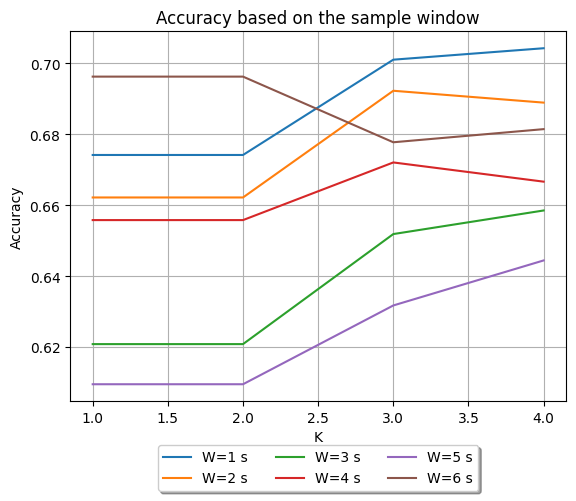

In [247]:
# TO TEST THE BEST WINDOW SAMPLING 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

ACCURACY = []
sample_windows = [1,2,3,4,5,6] # seconds
for W in sample_windows:
  scaler = StandardScaler()   
  X = process_packets(W)
  X = X.dropna()
  Y = X["gt"]
  X = X.drop('gt',axis=1)

  X_norm = scaler.fit_transform(X)
  
  X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.5)
  W_ACCURACY = []
  for k in range(1,5):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    knn_predict = knn.predict(X_test)
    accuracy = accuracy_score(y_test, knn_predict)
    W_ACCURACY.append(accuracy)
  ACCURACY.append(W_ACCURACY)

fig = plt.figure()
plt.grid(visible=True)
plt.title("Accuracy based on the sample window")
plt.xlabel('K')
plt.ylabel('Accuracy')
for i,w_accuracy in enumerate(ACCURACY):
  plt.plot(range(1,5),w_accuracy, label="W={} s".format(sample_windows[i]))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fancybox=True, shadow=True)
plt.show()

c. choose a pre-trained machine-learning classifier 
d. to recognize the user activity among at least the following
   - idle, web browsing, YouTube streaming
e. Report the accuracy of the approach through a confusion matrix

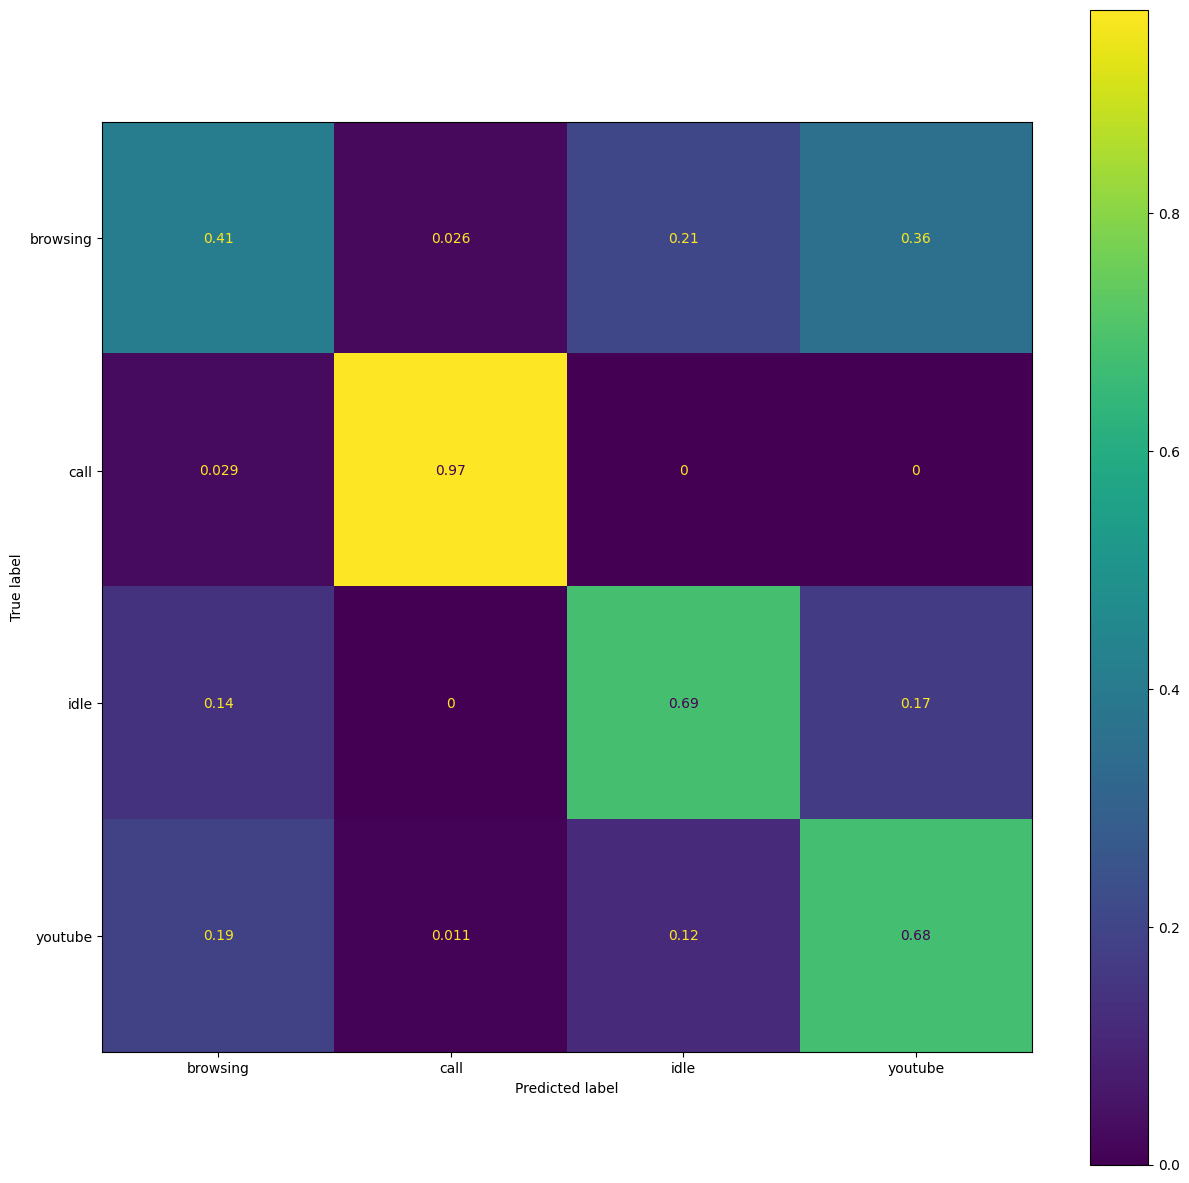

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

W = 1 # seconds
X = process_packets(W)
X = X.dropna()
Y = X["gt"]
X = X.drop('gt',axis=1)

bestk = np.argmax(ACCURACY[0])+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true')




In [269]:
#qos_data = processed_data["qos_type0","qos_type1","qos_type5","qos_type6","qos_type7"]

#general graphs
fig1, axs1 = plt.subplots(1,2)
fig1.set_size_inches(10, 5)

#qos graphs
fig2, axs2 = plt.subplots(4,2, sharex='col', sharey='row')
fig2.set_size_inches(10, 10)

general_parhs_tytles = [
    "Traffic Curve by activity",
    "Upload Traffic Curve by activity"
]    

qos_types = {
    "qos_type0": "Best Effort QoS Packets by activity",
    "qos_type7": "Network Controll (Voice) QoS Packets by activity",
    "qos_type2": "Spare (Bckg) QoS Packets by activity",
    "qos_type3": "Excelent (Best Effort) QoS Packets by activity",
    "qos_type4": "Controlled Local (Video) QoS Packets by activity",
    "qos_type5": "Video QoS Packets by activity",
    "qos_type6": "Voice QoS Packets by activity",
    "qos_type1": "Background QoS Packets by activity",
}

for i,ax in enumerate(axs2.reshape(-1)):
    ax.grid(visible=True)
    if not (i % 2) :
        ax.set_ylabel('Bytes')
    ax.set_xlim([-10,600])
    ax.set_ylim([-1,10])

for i,ax in enumerate(axs1.reshape(-1)):
    ax.grid(visible=True)
    if not (i % 2) :
        ax.set_ylabel('MB')
    ax.ticklabel_format(style='sci', axis="y", scilimits=(6,6))
    ax.set_xlim([-10,600])
    ax.set_ylim([-5e5,25e6])

for i,ax in enumerate(axs1.reshape(-1)):
    ax.set_title(general_parhs_tytles[i])

processed_data = load_data('./traffic_stats.csv')
for index,label in enumerate(application_types):
    activity_prodata = processed_data.groupby("gt").get_group(label)
    packet_acc_count = (activity_prodata["count"]*activity_prodata["avrg_len"]).cumsum()
    packet_upload_count = (activity_prodata["upload_percentage"]*activity_prodata["count"]*activity_prodata["avrg_len"]).cumsum()
    X = activity_prodata["sample_no"]

    axs1[0].plot(X, packet_acc_count, label="{}".format(label))
    axs1[1].plot(X, packet_upload_count, label="{}".format(label))

    for i,ax in enumerate(axs2.reshape(-1)):
        if i == 0:
            ax.set_ylim([-1,205])
        ax.plot(X, activity_prodata[list(qos_types)[i]].cumsum(), label="{}".format(label))
        ax.set_title(list(qos_types.values())[i])

handles, labels = axs1[0].get_legend_handles_labels()
fig1.legend(handles, labels, loc='lower center',ncol=len(application_types))
fig2.legend(handles, labels, loc='lower center',ncol=len(application_types))
fig.tight_layout() 